# Evaluate fine-tuned model.

Author: Francesco Conti


### Imports

In [ ]:
# For Colab - uncomment and run the following to set up the repo
!pip install speechbrain

In [17]:
%%capture
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile

from huggingface_hub import hf_hub_download
from IPython.display import display
from speechbrain.dataio.dataio import read_audio
import torch


### Download data

You need to log in to HuggingFace to be able to download the dataset

In [3]:
# define function to download data from hf_hub

def download_data(dest="data"):

    if os.path.exists(os.path.join(dest, "audio", "train")):
        print(
            f"It appears that data is already downloaded. \nIf you think it should be re-downloaded, remove {dest}/ directory and re-run"
        )
        return

    # download data from Huggingface
    for file_name in ["metadata.csv", "audio.zip", "dev_pairs.csv", "test_pairs.csv", "sample_submission.csv"]:

        hf_hub_download(
            repo_id="Ubenwa/CryCeleb2023",
            filename=file_name,
            local_dir=dest,
            repo_type="dataset",
        )

    with zipfile.ZipFile(os.path.join(dest, "audio.zip"), "r") as zip_ref:
        zip_ref.extractall(dest)

    print("Data downloaded to {dest}/ directory")

dataset_path = "data"

In [ ]:
# Verify your token. Yuo have to accept the condition to download the data from Ubenwa/CryCeleb2023
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# Download the data if you haven't already downloaded with train.ipynb
download_data(dataset_path)

In [6]:
# read metadata csv and get the training split
metadata = pd.read_csv(
    f"{dataset_path}/metadata.csv", dtype={"baby_id": str, "chronological_index": str}
)

### Evaluate Performance on Dev-Set
You can now use embedding_model.ckpt from this recipe and use it in evaluate.ipynb to verify pairs of cries and submit your results!

In [7]:
from speechbrain.pretrained import EncoderClassifier, SpeakerRecognition
from speechbrain.utils.metric_stats import EER

In [ ]:
# read metadata
metadata = pd.read_csv(
    f"{dataset_path}/metadata.csv", dtype={"baby_id": str, "chronological_index": str}
)
dev_metadata = metadata.loc[metadata["split"] == "dev"].copy()
# read sample submission
sample_submission = pd.read_csv(
    f"{dataset_path}/sample_submission.csv"
)  # scores are unfiorm random
# read verification pairs
dev_pairs = pd.read_csv(
    f"{dataset_path}/dev_pairs.csv", dtype={"baby_id_B": str, "baby_id_D": str}
)
test_pairs = pd.read_csv(f"{dataset_path}/test_pairs.csv")

display(
    metadata.head()
    .style.set_caption("metadata")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)
display(
    dev_pairs.head()
    .style.set_caption("dev_pairs")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)
display(
    test_pairs.head()
    .style.set_caption("test_pairs")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)
display(
    sample_submission.head()
    .style.set_caption("sample_submission")
    .set_table_styles([{"selector": "caption", "props": [("font-size", "20px")]}])
)

In [ ]:
!gdown https://drive.google.com/uc?id=1eZnYIlL5ZrLKoqBoEUow9M_EfX1Xt0MQ -O ./models/best_model.ckpt

In [ ]:
# Copy one of the best model in the spkrec-ecapa-voxceleb folder
!rm ./spkrec-ecapa-voxceleb/embedding_model.ckpt

!cp ./models/best_model.ckpt ./models/embedding_model.ckpt
!mv ./models/embedding_model.ckpt ./spkrec-ecapa-voxceleb/embedding_model.ckpt

In [ ]:
# Initialize a SpeackerRecognition object with fine-tuned model
encoder = SpeakerRecognition.from_hparams(
   source="speechbrain/spkrec-ecapa-voxceleb",
   savedir="spkrec-ecapa-voxceleb",
   run_opts={"device": "cuda"},  # comment out if no GPU available
)

In [ ]:

# read the segments
dev_metadata["cry"] = dev_metadata.apply(
    lambda row: read_audio(f'{dataset_path}/{row["file_name"]}').numpy(), axis=1
)
# concatenate all segments for each (baby_id, period) group
cry_dict = pd.DataFrame(
    dev_metadata.groupby(["baby_id", "period"])["cry"].agg(lambda x: np.concatenate(x.values)),
    columns=["cry"],
).to_dict(orient="index")
# encode the concatenated cries
for (baby_id, period), d in tqdm(cry_dict.items()):
    d["cry_encoded"] = encoder.encode_batch(torch.tensor(d["cry"]), normalize=False)

In [ ]:
def compute_cosine_similarity_score(row, cry_dict):
    cos = torch.nn.CosineSimilarity(dim=-1)
    similarity_score = cos(
        cry_dict[(row["baby_id_B"], "B")]["cry_encoded"],
        cry_dict[(row["baby_id_D"], "D")]["cry_encoded"],
    )
    return similarity_score.item()


dev_pairs["score"] = dev_pairs.apply(
    lambda row: compute_cosine_similarity_score(row=row, cry_dict=cry_dict), axis=1
)

dev_pairs

In [ ]:
dev_pairs[dev_pairs.label == 1]

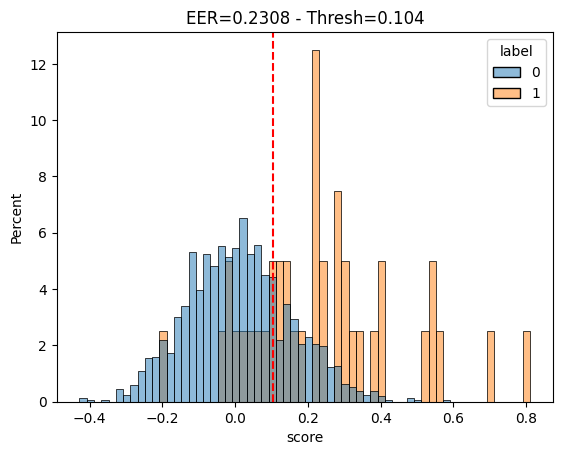

In [21]:
import matplotlib.pyplot as plt
def compute_eer_and_plot_verification_scores(pairs_df):
    """pairs_df must have 'score' and 'label' columns"""
    positive_scores = pairs_df.loc[pairs_df["label"] == 1]["score"].values
    negative_scores = pairs_df.loc[pairs_df["label"] == 0]["score"].values
    eer, threshold = EER(torch.tensor(positive_scores), torch.tensor(negative_scores))
    ax = sns.histplot(pairs_df, x="score", hue="label", stat="percent", binwidth=0.02, common_norm=False)
    ax.set_title(f"EER={round(eer, 4)} - Thresh={round(threshold, 4)}")
    plt.axvline(x=[threshold], color="red", ls="--")
    return eer, threshold


eer, threshold = compute_eer_and_plot_verification_scores(pairs_df=dev_pairs)

### Produce the submission csv

In [ ]:
%%time
test_metadata = metadata.loc[metadata["split"] == "test"].copy()
# read the segments
test_metadata["cry"] = test_metadata.apply(
    lambda row: read_audio(f'{dataset_path}/{row["file_name"]}').numpy(), axis=1
)
# concatenate all segments for each (baby_id, period) group
cry_dict_test = pd.DataFrame(
    test_metadata.groupby(["baby_id", "period"])["cry"].agg(lambda x: np.concatenate(x.values)),
    columns=["cry"],
).to_dict(orient="index")
# encode the concatenated cries
for (baby_id, period), d in tqdm(cry_dict_test.items()):
    d["cry_encoded"] = encoder.encode_batch(torch.tensor(d["cry"]), normalize=False)

# compute cosine similarity between all pairs
test_pairs["score"] = test_pairs.apply(
    lambda row: compute_cosine_similarity_score(row=row, cry_dict=cry_dict_test), axis=1
)
display(test_pairs.head())

In [ ]:

# submission must match the 'sample_submission.csv' format exactly
my_submission = test_pairs[["id", "score"]]
my_submission.to_csv("triplet_loss_submission.csv", index=False)
display(my_submission.head())